In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import transformers
import numpy as np
import codecs
import tensorflow as tf
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import warnings
import tensorflow_datasets as tfds
import tensorflow as tf
import joblib
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Progbar
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
data=pd.read_csv("/kaggle/input/data-good/MENTAL_HEALTH_DATA_New.csv")
data

,question,answer
0,i am not feeling well i feel really weak hopel...,im sorry to hear that but do not worry this is...
1,well where do i begin with those instructions ...,i want you to know that adhd depression is a t...
2,who are the people with expertise in the field...,the people who can give you a helping hand to ...
3,what if i dont seek help from you or those exp...,if you dont seek help from me or people with e...
4,what areas of life can adhd affect,difficulties in focusing and paying attention ...
...,...,...
3541,what are some strategies that can help individ...,strategies such as using memory aids eg calend...
3542,can neurocognitive disorders cause disruptions...,yes neurocognitive disorders can lead to disru...
3543,how might neurocognitive disorders impact a pe...,neurocognitive disorders can hinder the abilit...
3544,can neurocognitive disorders cause difficultie...,yes neurocognitive disorders can impair spatia...


In [4]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2, random_state=4)

In [5]:
train['question'][6]

'how does hyperactivity disorder affect the difficulty of forming personal relationships'

In [6]:
train['answer'][6]
"of course hyperactivity disorder and attention deficit negatively affect the formation of personal relationships because it always makes you in a state of tension and anxiety from others so that they do not bully your actions and the involuntary movements that you do and this makes it difficult for you to deal with people even the psychotherapist or people with professional assistance in that the field"

'of course hyperactivity disorder and attention deficit negatively affect the formation of personal relationships because it always makes you in a state of tension and anxiety from others so that they do not bully your actions and the involuntary movements that you do and this makes it difficult for you to deal with people even the psychotherapist or people with professional assistance in that the field'

In [7]:
vocab_ans = list(set(" ".join(train['answer'].values).split()))
vocab_ques = list(set(" ".join(train['question'].values).split()))
vocab_size_ans, vocab_size_ques = len(vocab_ans), len(vocab_ques)
print(f"vocab_size_ans, vocab_size_ques:{vocab_size_ans},{ vocab_size_ques}")

vocab_size_ans, vocab_size_ques:4545,2141


In [8]:
tokenizer_a = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['answer'], target_vocab_size=2**15) 

tokenizer_q = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['question'], target_vocab_size=2**15)

In [9]:
print(f"tokenizer_q:{tokenizer_q.vocab_size}")
print(f"tokenizer_a:{tokenizer_a.vocab_size}")

tokenizer_q:2816
tokenizer_a:5563


In [10]:
sample_string = 'Encoder decoder'

tokenized_string = tokenizer_a.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_a.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_a.decode([token]))

print("="*80)
tokenized_string = tokenizer_q.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_q.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_q.decode([token]))

Tokenized string is [5376, 5417, 5406, 5418, 5407, 5408, 5421, 5339, 5407, 5408, 5406, 5418, 5407, 5408, 5421]
The original string: Encoder decoder
5376---->E
5417---->n
5406---->c
5418---->o
5407---->d
5408---->e
5421---->r
5339----> 
5407---->d
5408---->e
5406---->c
5418---->o
5407---->d
5408---->e
5421---->r
Tokenized string is [2629, 2670, 2659, 2671, 2660, 2661, 2674, 2592, 2660, 2661, 2659, 2671, 2660, 2661, 2674]
The original string: Encoder decoder
2629---->E
2670---->n
2659---->c
2671---->o
2660---->d
2661---->e
2674---->r
2592----> 
2660---->d
2661---->e
2659---->c
2671---->o
2660---->d
2661---->e
2674---->r


In [11]:
def encode(ques, ans):
    ques = [tokenizer_q.vocab_size] + tokenizer_q.encode(ques.numpy()) + [tokenizer_q.vocab_size+1]
    ans = [tokenizer_a.vocab_size] + tokenizer_a.encode(ans.numpy()) + [tokenizer_a.vocab_size+1]
    return ques, ans

def tf_encode(ques, ans):
    result_ques, result_ans = tf.py_function(encode, [ques, ans], [tf.int64, tf.int64])
    result_ques.set_shape([None])
    result_ans.set_shape([None])
    return result_ques, result_ans

In [12]:
print(train['question'].values[0],"\n",train['answer'].values[0])
question, answer = tf_encode(train['question'].values[0],train['answer'].values[0])
print(question)
print(answer)

can factitious disorder coexist with other mental health conditions 
 factitious disorder can coexist with other mental health conditions such as personality disorders depression anxiety or substance use disorders which may complicate the diagnosis and treatment process
tf.Tensor([2816    1   30   17  172    6   55   31   49   82 2817], shape=(11,), dtype=int64)
tf.Tensor(
[5563   58   13    5  639    9   54   26   33   62   25   11  110   14
   35   23    7  276  312   14   73   18 1746    4  209    1   31  605
 5564], shape=(29,), dtype=int64)


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(dict(train))
train_dataset = train_dataset.map(lambda x:tf_encode(x['question'], x['answer']))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(20000).padded_batch(64, padded_shapes=([None],[None])) 
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) 

In [14]:
val_dataset = tf.data.Dataset.from_tensor_slices(dict(validation))
val_dataset = val_dataset.map(lambda x:tf_encode(x['question'], x['answer']))
val_dataset = val_dataset.padded_batch(64, padded_shapes=([None],[None]))

In [15]:
question, answer = next(iter(train_dataset))
question

<tf.Tensor: shape=(64, 29), dtype=int64, numpy=
array([[2816,  142,    9, ...,    0,    0,    0],
       [2816,    1,  146, ...,    0,    0,    0],
       [2816,    1,   62, ...,    0,    0,    0],
       ...,
       [2816,   11,   93, ...,    0,    0,    0],
       [2816,    1, 1433, ...,    0,    0,    0],
       [2816,    1,  164, ...,    0,    0,    0]])>

(1, 50, 512)


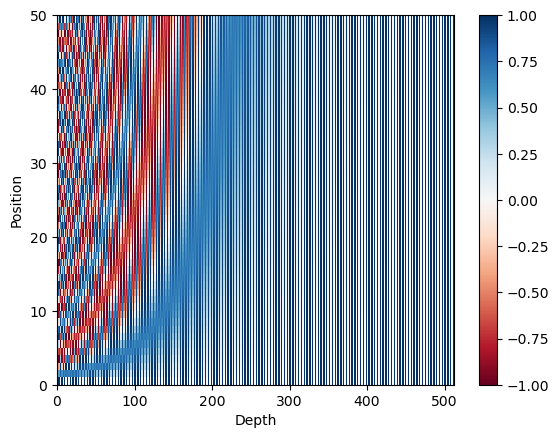

In [16]:
# Positional encoding


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis,:]

    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [17]:
# Masking

'''Mask all the pad tokens in the batch of sequence. 
It ensures that the model does not treat padding as the input. 
The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.
'''
def create_padding_mask(seq):
    """
    seq: padded sentence length (5)
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Adding 2, 3 dimn using tf.newaxis, 2-> As this mask will be multiplied with each attention head and 3-> for each word in a sentance
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
# create_padding_mask(np.array([[1,2,3,0,0,0],[1,2,3,0,0,1]]))

In [18]:
# Looakahead mask

"""The look-ahead mask is used to mask the future tokens in a sequence. 
In other words, the mask indicates which entries should not be used.
"""
def create_look_ahead_mask(size):
    """
    The look-ahead mask is used to mask the future tokens in a sequence
    """
    #band_part with this setting creates lower triangular matrix that's why subtracting from 1
    # [[0., 1., 1.],
    #  [0., 0., 1.],
    #  [0., 0., 0.]] output with size:3
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#example
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [19]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Args:
    q: query shape == (..., seq_len_q, depth) # NOTE: depth=dk
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """ 
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk. underroot d_model i.e. underroot(100)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor. 
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # -1e9 ~ (-INFINITY) => where ever mask is set, make its logit value close to -INF
    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # typically 512

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    

In [21]:
def point_wise_feed_forward_network(d_model, dff): #dff = 512
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model) # with Attention

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model) #with Attention

        return out2

In [22]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [23]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
         
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) 
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [24]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]   #x:(batch, seq_len)
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) 
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [25]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [26]:

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [27]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        #arg1 = tf.math.rsqrt(step)
        #arg2 = step * (self.warmup_steps ** -1.5)
        arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
        arg2 = tf.cast(step, tf.float32) * (tf.cast(self.warmup_steps, tf.float32) ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [29]:
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, 
                          target_vocab_size, pe_input=input_vocab_size, 
                          pe_target=target_vocab_size, rate=dropout_rate)

In [30]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

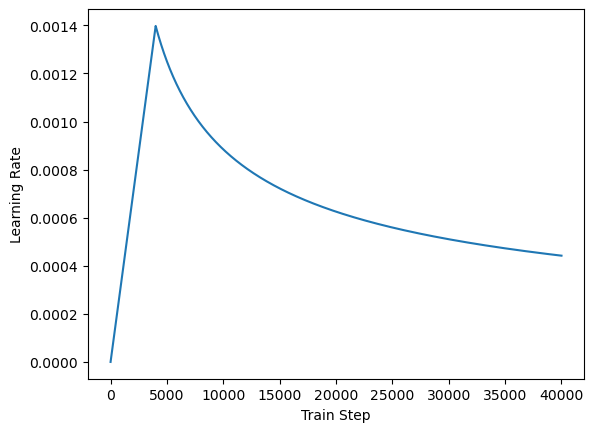

In [31]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [32]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [33]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [34]:
checkpoint_path = "./checkpoints_test/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [35]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp) 
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)
    

In [36]:
val_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=val_step_signature)
def val_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp) 
    predictions, _  = transformer(inp, tar_inp, False, enc_padding_mask, combined_mask, dec_padding_mask)

    loss = loss_function(tar_real, predictions)

    val_loss(loss)
    val_accuracy(tar_real, predictions)

In [37]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

sample_transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

temp_input = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)
sample_transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  1153792   
                                                                 
 decoder_1 (Decoder)         multiple                  1770624   
                                                                 
 dense_135 (Dense)           multiple                  717885    
                                                                 
Total params: 3,642,301
Trainable params: 3,642,301
Non-trainable params: 0
_________________________________________________________________


In [38]:
num_layers = 4
d_model = 1024
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1


transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [39]:
# EPOCHS = 500
# batch_size = 128
# metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
# for epoch in range(EPOCHS):
#     print("\nepoch {}/{}".format(epoch+1,EPOCHS))
#     pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
#     # inp -> question, tar -> answer
#     for (batch, (inp, tar)) in enumerate(train_dataset):
#         train_step(inp, tar)
        
#         values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
#         pb_i.add(batch_size, values=values) 

#     for (val_batch, (val_inp, val_tar)) in enumerate(val_dataset):
#         val_step(val_inp, val_tar)

#         values.append(('val_loss',val_loss.result()))
#         values.append(('val_acc',val_accuracy.result()))
#     pb_i.add(batch_size, values=values) 

                      
#     if (epoch + 1) % 5 == 0:
#         ckpt_save_path = ckpt_manager.save()
#         print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

In [40]:
EPOCHS = 500
batch_size = 1024
metrics_names = ['loss', 'acc'] 
train_loss.reset_states()
train_accuracy.reset_states()

train_acc_values = []
val_acc_values = []
train_loss_values = []
val_loss_values = []

best_val_loss = float('inf')
patience = 10  # Number of epochs to wait for improvement
no_improvement_count = 0

for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1, EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss', train_loss.result()), ('acc', train_accuracy.result())]
        pb_i.add(batch_size, values=values) 

    for (val_batch, (val_inp, val_tar)) in enumerate(val_dataset):
        val_step(val_inp, val_tar)

        values.append(('val_loss', val_loss.result()))
        values.append(('val_acc', val_accuracy.result()))
    pb_i.add(batch_size, values=values) 
    
    # Store accuracy values
    train_acc_values.append(train_accuracy.result())
    val_acc_values.append(val_accuracy.result())
    train_loss_values.append(train_loss.result())
    val_loss_values.append(val_loss.result())
    
    if val_loss.result() < best_val_loss:
        best_val_loss = val_loss.result()
        no_improvement_count = 0
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print('Early stopping. No improvement in validation loss for {} epochs.'.format(patience))
            break


epoch 1/500
47104/2836 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 87s 2ms/step - loss: 8.0903 - acc: 0.0089 - val_loss: 7.5288 - val_acc: 0.0095
Saving checkpoint for epoch 1 at ./checkpoints_test/train/ckpt-1

epoch 2/500
47104/2836 [================================================================================================================================================================================================================================================================================================================

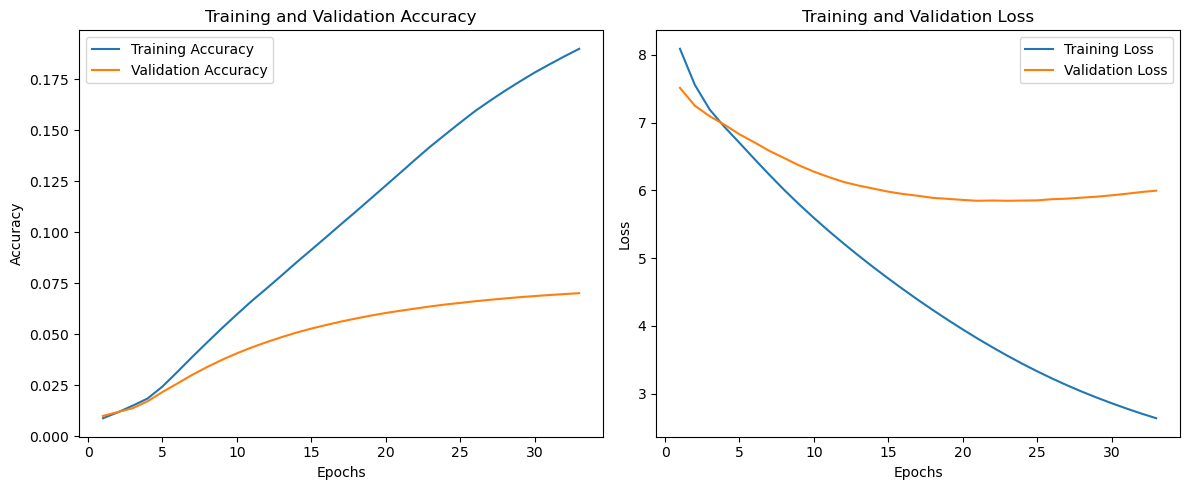

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training and Validation Accuracy
epochs = range(1, len(train_acc_values) + 1)
ax1.plot(epochs, train_acc_values, label='Training Accuracy')
ax1.plot(epochs, val_acc_values, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot Training and Validation Loss
epochs = range(1, len(train_loss_values) + 1)
ax2.plot(epochs, train_loss_values, label='Training Loss')
ax2.plot(epochs, val_loss_values, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
EPOCHS = 1000
batch_size = 
metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

In [ ]:
EPOCHS = 3000
batch_size = 64
metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

In [ ]:
EPOCHS = 400
batch_size = 64
metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

In [ ]:
EPOCHS = 500
batch_size = 64
metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

In [ ]:
# joblib.dump(tokenizer_q, "tokenizer_q")
# joblib.dump(tokenizer_a, "tokenizer_a")
# transformer.save_weights('transformer_model/weights')

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    sentence = sentence.split(" ")
    predicted_sentence = predicted_sentence.split(" ")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)



def plot_attention_weights(attention,tokenizer_q, tokenizer_a, sentence, result, layer):
    
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_q.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)
    #(1, 8, 5, 4) --> (8, 5, 4)
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights [:-1, :]
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        fontdict = {'fontsize': 10}
        
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)-1))

        ax.set_ylim(len(result)-1.5, -0.5)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        x = ['<start>']+[tokenizer_q.decode([i]) for i in sentence]+['<end>']
        y = [tokenizer_a.decode([i]) for i in result if i < tokenizer_a.vocab_size]
        ax.set_xticklabels([''] + x, fontdict=fontdict, rotation=90)
        ax.set_yticklabels([''] + y, fontdict=fontdict)


        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()
    
    
MAX_LENGTH = 140

def evaluate(inp_sentence, model,  tokenizer_q, tokenizer_a):
    start_token = [tokenizer_q.vocab_size]
    end_token = [tokenizer_q.vocab_size + 1]

    # All questions has the start and end token
    inp_sentence = start_token + tokenizer_q.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 'answers' start token : 27358
    decoder_input = [tokenizer_a.vocab_size]
    decoder_input = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = model(encoder_input, 
                                                     decoder_input,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_a.vocab_size+1:
            print(f"=============\nGot end token\n=============")
            return tf.squeeze(decoder_input, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

    return tf.squeeze(decoder_input, axis=0), attention_weights

In [49]:
def reply(sentence, transformer,  tokenizer_q, tokenizer_a, plot=''):
    result, attention_weights = evaluate(sentence, transformer,  tokenizer_q, tokenizer_a)
#     print("Attention_Blocks:", list(attention_weights.keys()))
    predicted_sentence = tokenizer_a.decode([i for i in result 
                                            if i < tokenizer_a.vocab_size])  
  
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
    if plot:
        plot_attention_weights(attention_weights,tokenizer_q, tokenizer_a, sentence, result, plot)
    return sentence, predicted_sentence

Got end token
Input: how does hyperactivity disorder affect the difficulty of forming personal relationships
Predicted translation: of course hyperactivity disorder and attention deficit negatively affect the formation of anxiety disorders always makes it always makes you in a state of tension and anxiety from others so they may develop in a person may take but they can always result in a person may have difficulty understanding and rules and coping strategies such as directed and support


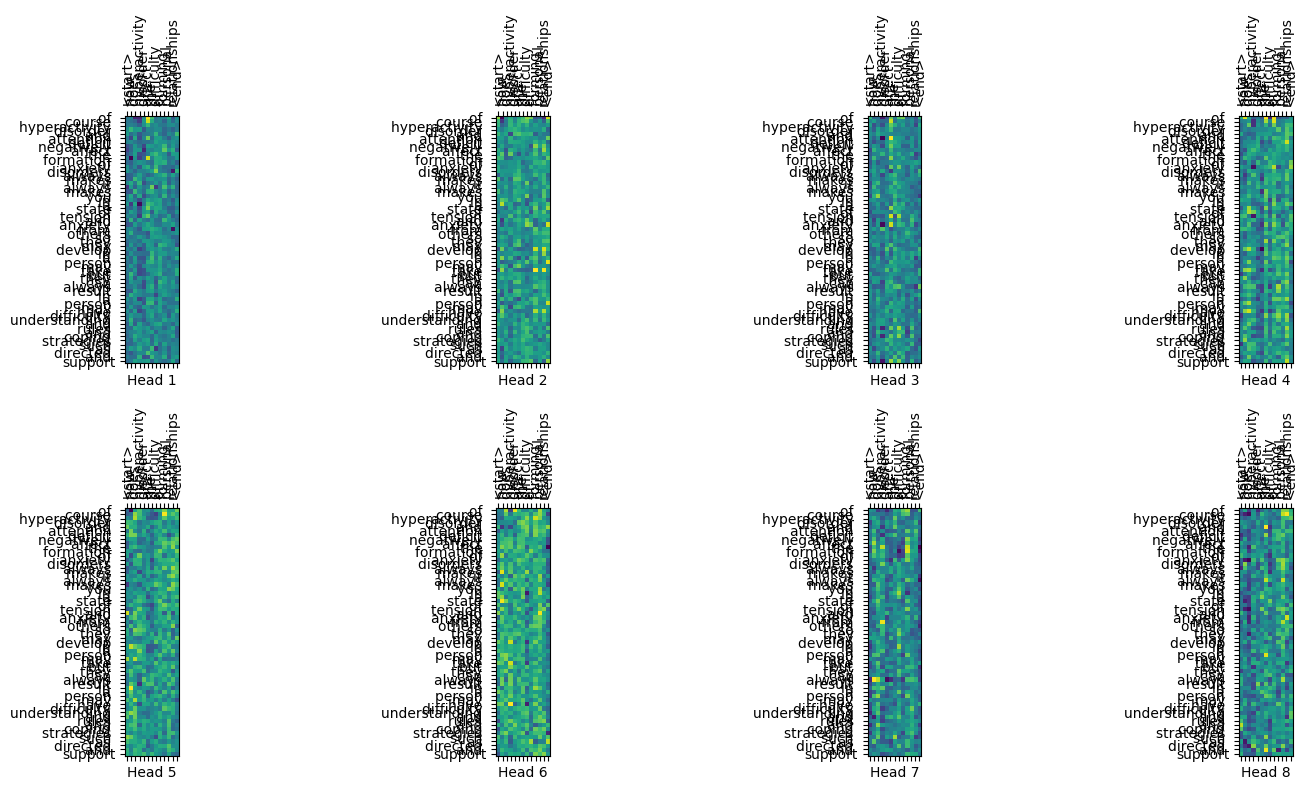

'without seeking help for adhd you may face difficulties in concentration organization impulse control and overall functioning in various aspects of life such as school work and relationships'

In [50]:
inp_sentence = "how does hyperactivity disorder affect the difficulty of forming personal relationships"
reply(inp_sentence, transformer,  tokenizer_q, tokenizer_a, "decoder_layer2_block2")
'without seeking help for adhd you may face difficulties in concentration organization impulse control and overall functioning in various aspects of life such as school work and relationships'

In [51]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
test_q = validation["question"].values[:10]
test_a = validation["answer"].values[:10]
bss = []
for i in range(10):
    input_test_sentence = test_q[i]
    input_sentence, pred_string = reply(input_test_sentence, transformer,  tokenizer_q, tokenizer_a, plot='')
    print("Actual:", test_a[i])
    reference = [test_a[i].split()] # the original
    translation = pred_string.split() # trasilated using model
    bs = bleu.sentence_bleu(reference, translation)
    print(bs)
    bss.append(bs)

Got end token
Input: how can practicing good sleep hygiene help in managing excessive sleepiness
Predicted translation: excessive sleepiness can significantly impact a persons quality of sleep often involves excessive sleepiness daytime sleepiness irritability and difficulty concentrating effectively
Actual: practicing good sleep hygiene involves adopting habits such as maintaining a consistent sleep schedule creating a conducive sleep environment and avoiding stimulants before bedtime which can help improve sleep quality and reduce excessive sleepiness
0.20003740369457226
Got end token
Input: can therapy be beneficial for individuals with this mood disorder
Predicted translation: yes therapy such as cognitivebehavioral therapy cbt is an effective treatment for therapy for persistent mental health professionals can help individuals with depression
Actual: therapy such as cognitivebehavioral therapy cbt can help individuals develop coping strategies and provide emotional support to mana